In [15]:
from argparse import Namespace
import time
import random
import numpy as np
import torch
from my_code.data_generation import generate_tables, generate_tables2
from my_code.blocking import run_blocking
from my_code.summarizer import Summarizer
from my_code.DK import GeneralDKInjector
from my_code.dataset import DittoDataset
from my_code.utils import train
from my_code.utils import plot_metrics, normalize_columns, fetch_from_hive

In [16]:
def run_full_pipeline(hp, config):
    """
    Run the full DITTO pipeline:
    - Data blocking
    - Summarization (optional)
    - Domain Knowledge (DK) injection (optional)
    - Dataset preparation
    - Model training and evaluation
    - Metrics visualization
    """

    # Extract dataset file paths from configuration
    trainset = config['trainset']
    validset = config['validset']
    testset = config['testset']
    
    # ------------------------------
    # Step 1: Blocking
    # ------------------------------
    # Reduces candidate pairs for entity matching by filtering obvious non-matches.
    run_blocking(hp)

    # ------------------------------
    # Step 2: Summarization (Optional)
    # ------------------------------
    # Summarizer shortens entity descriptions while retaining important info.
    # Useful for long texts to fit within transformer input limits.
    if hp.summarize:
        summarizer = Summarizer(config, hp.lm)
        trainset = summarizer.transform_file(trainset, max_len = hp.max_len, overwrite=hp.overwrite)
        testset = summarizer.transform_file(testset, max_len = hp.max_len, overwrite=hp.overwrite)
        validset = summarizer.transform_file(validset, max_len = hp.max_len, overwrite=hp.overwrite)

    # ------------------------------
    # Step 3: Domain Knowledge Injection (Optional)
    # ------------------------------
    # Injects external domain knowledge (DK) into the data to enrich features.
    if hp.dk is not None:
        injector = GeneralDKInjector(config, hp.dk)
        trainset = injector.transform_file(trainset, overwrite=hp.overwrite)
        validset = injector.transform_file(validset, overwrite=hp.overwrite)
        testset = injector.transform_file(testset, overwrite=hp.overwrite)

    # ------------------------------
    # Step 4: Dataset Preparation
    # ------------------------------
    # Converts text files into DittoDataset objects compatible with transformers.
    # It does contain data augmentation.
    train_dataset = DittoDataset(trainset,
                                   lm=hp.lm,
                                   max_len=hp.max_len,
                                   size=hp.size,
                                   da=hp.da)
    valid_dataset = DittoDataset(validset, lm=hp.lm)
    test_dataset = DittoDataset(testset, lm=hp.lm)
    
    # ------------------------------
    # Step 5: Training
    # ------------------------------
    # Fine-tunes the transformer model (BERT, RoBERTa, etc.) on entity matching.
    # Also evaluates on validation & test sets, and logs results.
    t1 = time.time()
    csv_log_path = train(train_dataset, valid_dataset, test_dataset, run_tag="test_run", hp=hp)
    t2 = time.time()
    print(f"Training time: {round(t2-t1, 3)} seconds")

    # ------------------------------
    # Step 6: Metrics Visualization
    # ------------------------------
    plot_metrics(csv_log_path)

In [17]:
def main(hp, config):
    """
    Main entry point for the DITTO pipeline.
    - Handles data preparation (either generated or fetched from Hive).
    - Normalizes columns using a mapping file.
    - Runs the full training pipeline.
    """

    # ------------------------------
    # Reproducibility: set all seeds
    # ------------------------------
    SEED = 42
    random.seed(SEED)                # Python RNG
    np.random.seed(SEED)             # NumPy RNG
    torch.manual_seed(SEED)          # PyTorch (CPU)
    torch.cuda.manual_seed(SEED)     # Single GPU
    torch.cuda.manual_seed_all(SEED) # All GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------------------------------------------------------------------------
    # Case 1: Generate synthetic data
    # ---------------------------------------------------------------------------------------------
    #TO UPDATE IF NEEDED FOR DATA GENERATION
    if hp.task == "Generated_data":
        # Create synthetic source and reference tables
        generate_tables2(base_path=hp.base_path_blocking, 
                        n_total=30,                    # total number of records
                        match_ratio=0.3                 # proportion of matches vs. non-matches
        )

        # Normalize columns (map field names consistently using mapping.json)
        normalize_columns(df_path=hp.table_reference_csv, json_file="my_code/mapping.json")
        normalize_columns(df_path=hp.table_source_csv, json_file="my_code/mapping.json")

    # ---------------------------------------------------------------------------------------------
    # Case 2: Fetch real data from Hive
    # ---------------------------------------------------------------------------------------------
    #If the data already exist make sure to add the task name to configs and also use it hp.task and put the data in base_path_training/data/{task_training_name}   (reference and source)
    else:
        # Extract source and reference tables from Hive DB
        fetch_from_hive(
            hive_host=hp.hive_host,
            hive_port=hp.hive_port,
            hive_user=hp.hive_user,
            hive_database=hp.hive_database,
            source_table=hp.source_table,
            reference_table=hp.reference_table,
            source_csv_path=hp.table_source_csv,
            reference_csv_path=hp.table_reference_csv
        )

        # Normalize column names after fetching
        normalize_columns(df_path=hp.table_reference_csv, json_file="my_code/mapping.json")
        normalize_columns(df_path=hp.table_source_csv, json_file="my_code/mapping.json")
    
    # ---------------------------------------------------------------------------------------------
    # Run the full Ditto pipeline (blocking → preprocessing → training → metrics)
    # ---------------------------------------------------------------------------------------------
    run_full_pipeline(hp, config)

Generating 30 records:
9 matching pairs (30%)
21 non-matching records

📁 Files saved
 - Reference: 9 rows
 - Source:    30 rows
 - Ground Truth: 26 pairs
   - Matches: 9
   - Non-matches: 17
Cleaning mapping json file done.
✅ Normalized and saved CSV at: D:/Study/ENSIAS/stage_2/ER/ditto/resultat_training/data/Generated_data/reference_table.csv
Cleaning mapping json file done.
✅ Normalized and saved CSV at: D:/Study/ENSIAS/stage_2/ER/ditto/resultat_training/data/Generated_data/source_table.csv


c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]



📊 Blocking Metrics:
 - Total candidate pairs generated: 150
 - Total true matches in ground truth: 9
 - Predicted positive pairs (label=1): 48
 - Correctly predicted matches: 9
 - Recall:           1.0000
 - Precision:        0.1875
 - Reduction Ratio:  0.4444

✅ Blocking completed: 96 balanced pairs written to:

📁 Split saved


Epoch 1
  Time: 30.26 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6429 | Threshold: 0.00
  Validation Accuracy: 0.4737
  Validation Precision: 0.4737
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667
Training time: 32.059 seconds


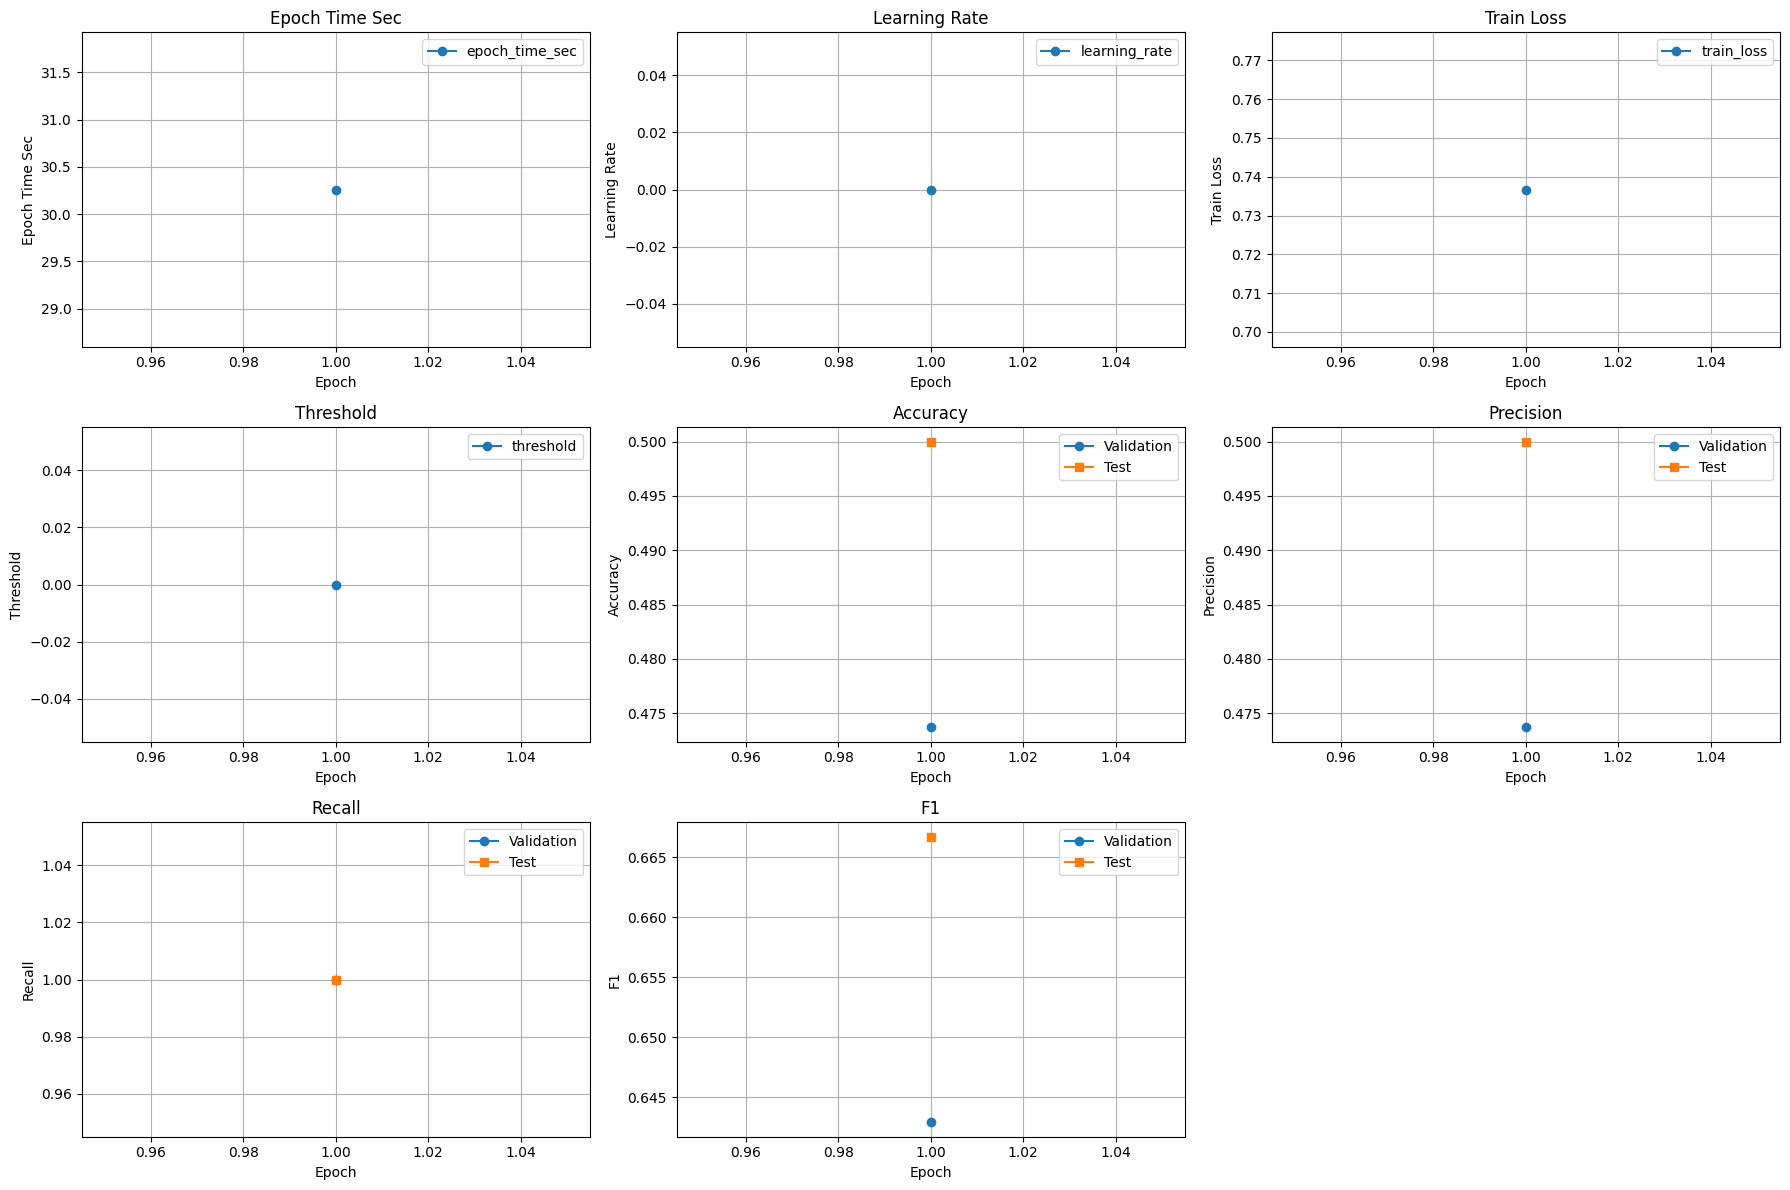

In [18]:
# ---------------------------------------------------------------------------------------------
# Base path for storing generated or fetched datasets
base_path_training = "D:/Study/ENSIAS/stage_2/ER/ditto/resultat_training"  # Update to your project root

# -------------------- task Selection --------------------
# Choose the task/dataset you want to work with:
# - "Generated_data" → Use synthetic data generated by the script
# - Any other name → Use your own dataset fetched from Hive
task_training = "Generated_data"

# -------------------- Hive Configuration --------------------
# If you want to fetch your dataset from Hive, provide these parameters.
# Otherwise, keep them as None when using generated data.
hive_host = None        # Hive server host
hive_port = None        # Hive server port
hive_user = None        # Hive username
hive_database = None    # Hive database name
source_table = None     # Hive source table name
reference_table = None  # Hive reference table name
# ---------------------------------------------------------------------------------------------

hp_training = Namespace(
    # -----------------------------------------------------------------------------------------
    #Hive configuration (used when fetching data from Hive instead of generating synthetic data)
    hive_host = hive_host,                          # Hive server host
    hive_port = hive_port,                          # Hive server port
    hive_user = hive_user,                          # Hive username for authentication
    hive_database = hive_database,                  # Hive database name to query
    source_table = source_table,                    # Source table name
    reference_table = reference_table,              # Reference table name
    # -----------------------------------------------------------------------------------------

    # -----------------------------------------------------------------------------------------
    # Hyperparameters for blocking step
    model_name_blocking="all-MiniLM-L12-v2",        # Sentence-transformers model for embeddings
    top_k_blocking=5,                               # Number of top candidates to keep per record
    threshold_blocking=0.95,                        # Similarity threshold for candidate pairs
    batch_size_blocking=512,                        # Batch size for encoding embeddings
    # -----------------------------------------------------------------------------------------

    # Base path for saving/loading all intermediate data
    base_path_blocking=base_path_training,

    # -----------------------------------------------------------------------------------------
    # Input/Output paths (auto-generated from base_path_training and task_training)
    # ⚠️ Users do NOT need to modify these manually
    # -----------------------------------------------------------------------------------------
    # Input CSVs
    table_reference_csv=f"{base_path_training}/data/{task_training}/reference_table.csv",
    table_source_csv=f"{base_path_training}/data/{task_training}/source_table.csv",
    ground_truth_csv=f"{base_path_training}/data/{task_training}/ground_truth.csv",

    # Ditto-style TXT files (entity tables in text format used for training Ditto)
    table_reference_txt=f"{base_path_training}/input_txt_blocking/{task_training}/reference_table.txt",
    table_source_txt=f"{base_path_training}/input_txt_blocking/{task_training}/source_table.txt",

    # Precomputed vector files (embeddings stored for efficiency)
    table_reference_vec=f"{base_path_training}/vectors_blocking/{task_training}/reference_table.txt.mat",
    table_source_vec=f"{base_path_training}/vectors_blocking/{task_training}/source_table.txt.mat",

    # Blocking outputs
    output_pairs_csv=f"{base_path_training}/blocking/{task_training}/blocking_pairs.csv",
    output_ditto_txt=f"{base_path_training}/blocking/{task_training}/blocking_pairs_ditto.txt",

    # Inference output
    output_inference_csv=f"{base_path_training}/inference/{task_training}/result.csv",

    dataset_csv_dir=f"{base_path_training}/dataset_ditto_csv",
    dataset_txt_dir=f"{base_path_training}/dataset_ditto_txt",

    # Logging and task_training info
    logdir="./logs",                                # Where to store logs, metrics, and checkpoints
    task=task_training,                             # Current task name (used for organizing paths)

    # -----------------------------------------------------------------------------------------
    # Hyperparameters for training
    batch_size=32,                                  # Batch size for training transformer
    lr=3e-5,                                        # Learning rate for AdamW optimizer
    epochs=1,                                       # Number of training epochs        
    save_model=True,                                # Whether to save the trained model
    lm="distilbert",                                # Transformer language model backbone
    size=None,                                      # Optional subset size of training data (None = use all)
    alpha_aug=0.8,                                  # Data augmentation strength (for Ditto's augmentation)
    max_len=256,                                    # Max token length for summarizing
    da="all",                                       # Data augmentation strategy (e.g., "swap", "drop", "all") "all" recommended
    summarize=True,                                 # Whether to apply summarization step
    dk=True,                                        # Whether to inject domain knowledge (DK)
    fp16=True,                                      # Use mixed precision training (faster on GPU with less memory)
    overwrite=True,                                 # Overwrite intermediate files if they exist
    columns_to_use = None                           # Columns from source/reference tables to include (None = all)
    # -----------------------------------------------------------------------------------------
)

# The `configs` list tells the project where to find train/validation/test data
# Each task needs a dictionary with the paths to its dataset files.
# Example structure:
configs = [{
    "name": "Generated_data",
    "trainset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/train.txt",
    "validset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/valid.txt",
    "testset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/test.txt"
},
{
    "name": "data_1",
    "trainset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/train.txt",
    "validset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/valid.txt",
    "testset": f"{hp_training.base_path_blocking}/dataset_ditto_txt/{hp_training.task}/test.txt"
}
]

configs = {conf['name'] : conf for conf in configs}
config = configs[hp_training.task]

main(hp_training, config)